# SSL: Co-Regression

Max Calzada

Last Updated: 2023 April 29



# [Co-Regression](https://www.ijcai.org/Proceedings/05/Papers/0689.pdf) Model

This is the second complete Co-Reg model.

### Loading ETC Data:
`X_LBoB.npy` contains the observations and `y_LBoB.npy` contains the detonation values (variable of interest).

In [14]:
# Code based off of: https://github.com/ermongroup/ssdkl/blob/master/ssdkl/models/coreg.py

from time import time
import os

import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae # Max added this (and all other MAEs).

# regression
import statsmodels.api as sm
from scipy import stats

# visuals
import pandas as pd
import matplotlib.pyplot as plt


def load_data(data_dir):
    """
    Loads data from data directory.
    """
    X = np.load(os.path.join(data_dir, 'X_LBoB.npy')) # 'X.npy'
    y = np.load(os.path.join(data_dir, 'y_LBoB.npy')) # 'y.npy'
    return X, y.reshape(-1, 1)


class Coreg():
    """
    Instantiates a CoReg regressor.
    """
    def __init__(self, k1=3, k2=3, p1=2, p2=5, max_iters=100, pool_size=100):
        self.k1, self.k2 = k1, k2  # number of neighbors
        self.p1, self.p2 = p1, p2  # distance metrics
        self.max_iters = max_iters
        self.pool_size = pool_size
        self.h1 = KNeighborsRegressor(n_neighbors=self.k1, p=self.p1)
        self.h2 = KNeighborsRegressor(n_neighbors=self.k2, p=self.p2)
        self.h1_temp = KNeighborsRegressor(n_neighbors=self.k1, p=self.p1)
        self.h2_temp = KNeighborsRegressor(n_neighbors=self.k2, p=self.p2)

    def add_data(self, data_dir):
        """
        Adds data and splits into labeled and unlabeled.
        """
        self.X, self.y = load_data(data_dir)

    def run_trials(self, num_train=100, trials=10, verbose=False):
        """
        Runs multiple trials of training.
        """
        self.num_train = num_train
        self.num_trials = trials
        self._initialize_metrics()
        self.trial = 0
        while self.trial < self.num_trials:
            t0 = time()
            # print('Starting trial {}:'.format(self.trial + 1))
            self.train((self.trial+self.num_train), num_labeled, num_test, verbose, store_results=True)
            # self.train(
                # random_state=(self.trial+self.num_train),
                # num_labeled=self.num_train, num_test=1000, verbose=verbose,
                # store_results=True)
            # M: I edited this code because these hardcoded values do not allow the user inputs to change the model.
            # print('Finished trial {}: {:0.2f}s elapsed\n'.format(
                # self.trial + 1, time() - t0))
            tune_mses_test.append(self.mse_test)
            tune_mses_train.append(self.mse_train)
            tune_mses1_test.append(self.mse1_test)
            tune_mses1_train.append(self.mse1_train)
            tune_mses2_test.append(self.mse2_test)
            tune_mses2_train.append(self.mse2_train)

            tune_maes_test.append(self.mae_test)
            tune_maes_train.append(self.mae_train)
            tune_maes1_test.append(self.mae1_test)
            tune_maes1_train.append(self.mae1_train)
            tune_maes2_test.append(self.mae2_test)
            tune_maes2_train.append(self.mae2_train)
            self.trial += 1
            # maybe here

    def train(self, random_state=-1, num_labeled=100, num_test=1000,
              verbose=False, store_results=False):
        """
        Trains the CoReg regressor.
        """
        t0 = time()
        self._split_data(random_state, num_labeled, num_test)
        self._fit_and_evaluate(verbose)
        if store_results:
            self._store_results(0)
        self._get_pool()
        if verbose:
            # print('Initialized h1, h2: {:0.2f}s\n'.format(time()-t0))
            pass
        for t in range(1, self.max_iters+1):
            stop_training = self._run_iteration(t, t0, verbose, store_results)
            if stop_training:
              pass # Max added this


                # if verbose:
                    # print('Done in {} iterations: {:0.2f}s'.format(t, time()-t0))
                # break
        # if verbose:
            # print('Finished {} iterations: {:0.2f}s'.format(t, time()-t0))

    def _run_iteration(self, t, t0, verbose=False, store_results=False):
        """
        Run t-th iteration of co-training, returns stop_training=True if
        no more unlabeled points are added to label sets.
        """
        stop_training = False
        if verbose:
            # print('Started iteration {}: {:0.2f}s'.format(t, time()-t0))
            pass
        self._find_points_to_add()
        added = self._add_points()
        if added:
            self._fit_and_evaluate(verbose)
            if store_results:
                self._store_results(t)
            self._remove_from_unlabeled()
            self._get_pool()
        else:
            stop_training = True
        return stop_training

    def _add_points(self):
        """
        Adds new examples to training sets.
        """
        added = False
        if self.to_add['x1'] is not None:
            self.L2_X = np.vstack((self.L2_X, self.to_add['x1']))
            self.L2_y = np.vstack((self.L2_y, self.to_add['y1']))
            added = True
        if self.to_add['x2'] is not None:
            self.L1_X = np.vstack((self.L1_X, self.to_add['x2']))
            self.L1_y = np.vstack((self.L1_y, self.to_add['y2']))
            added = True
        return added

    def _compute_delta(self, omega, L_X, L_y, h, h_temp):
        """
        Computes the improvement in MSE among the neighbors of the point being
        evaluated.
        """
        delta = 0
        for idx_o in omega:
            delta += (L_y[idx_o].reshape(1, -1) -
                      h.predict(L_X[idx_o].reshape(1, -1))) ** 2
            delta -= (L_y[idx_o].reshape(1, -1) -
                      h_temp.predict(L_X[idx_o].reshape(1, -1))) ** 2
        return delta

    def _compute_deltas(self, L_X, L_y, h, h_temp):
        """
        Computes the improvements in local MSE for all points in pool.
        """
        deltas = np.zeros((self.U_X_pool.shape[0],))
        for idx_u, x_u in enumerate(self.U_X_pool):
            # Make prediction
            x_u = x_u.reshape(1, -1)
            y_u_hat = h.predict(x_u).reshape(1, -1)
            # Compute neighbors
            omega = h.kneighbors(x_u, return_distance=False)[0]
            # Retrain regressor after adding unlabeled point
            X_temp = np.vstack((L_X, x_u))
            y_temp = np.vstack((L_y, y_u_hat))  # use predicted y_u_hat
            h_temp.fit(X_temp, y_temp)
            delta = self._compute_delta(omega, L_X, L_y, h, h_temp)
            deltas[idx_u] = delta
        return deltas

    def _evaluate_metrics(self, verbose):
        """
        Evaluates KNN regressors on training and test data.
        """
        train1_hat = self.h1.predict(self.X_labeled)
        train2_hat = self.h2.predict(self.X_labeled)
        train_hat = 0.5 * (train1_hat + train2_hat)
        test1_hat = self.h1.predict(self.X_test)
        test2_hat = self.h2.predict(self.X_test)
        test_hat = 0.5 * (test1_hat + test2_hat)
        # mse
        self.mse1_train = mean_squared_error(train1_hat, self.y_labeled)
        self.mse1_test = mean_squared_error(test1_hat, self.y_test)
        self.mse2_train = mean_squared_error(train2_hat, self.y_labeled)
        self.mse2_test = mean_squared_error(test2_hat, self.y_test)
        self.mse_train = mean_squared_error(train_hat, self.y_labeled)
        self.mse_test = mean_squared_error(test_hat, self.y_test)
        # mae # Max added this.
        self.mae1_train = mae(train1_hat, self.y_labeled)
        self.mae1_test = mae(test1_hat, self.y_test)
        self.mae2_train = mae(train2_hat, self.y_labeled)
        self.mae2_test = mae(test2_hat, self.y_test)
        self.mae_train = mae(train_hat, self.y_labeled)
        self.mae_test = mae(test_hat, self.y_test)

        # if verbose:
            # print('MSEs:')
            # print('  KNN1:')
            # print('    Train: {:0.4f}'.format(self.mse1_train))
            # print('    Test : {:0.4f}'.format(self.mse1_test))
            # print('  KNN2:')
            # print('    Train: {:0.4f}'.format(self.mse2_train))
            # print('    Test : {:0.4f}'.format(self.mse2_test))
            # print('  Combined:')
            # print('    Train: {:0.4f}'.format(self.mse_train))
            # print('    Test : {:0.4f}\n'.format(self.mse_test))
            # print('MAEs:')
            # print('  KNN1:')
            # print('    Train: {:0.4f}'.format(self.mae1_train))
            # print('    Test : {:0.4f}'.format(self.mae1_test))
            # print('  KNN2:')
            # print('    Train: {:0.4f}'.format(self.mae2_train))
            # print('    Test : {:0.4f}'.format(self.mae2_test))
            # print('  Combined:')
            # print('    Train: {:0.4f}'.format(self.mae_train))
            # print('    Test : {:0.4f}\n'.format(self.mae_test))


    def _find_points_to_add(self):
        """
        Finds unlabeled points (if any) to add to training sets.
        """
        self.to_add = {'x1': None, 'y1': None, 'idx1': None,
                       'x2': None, 'y2': None, 'idx2': None}
        # Keep track of added idxs
        added_idxs = []
        for idx_h in [1, 2]:
            if idx_h == 1:
                h = self.h1
                h_temp = self.h1_temp
                L_X, L_y = self.L1_X, self.L1_y
            elif idx_h == 2:
                h = self.h2
                h_temp = self.h2_temp
                L_X, L_y = self.L2_X, self.L2_y
            deltas = self._compute_deltas(L_X, L_y, h, h_temp)
            # Add largest delta (improvement)
            sort_idxs = np.argsort(deltas)[::-1]  # max to min
            max_idx = sort_idxs[0]
            if max_idx in added_idxs:
                max_idx = sort_idxs[1]
            if deltas[max_idx] > 0:
                added_idxs.append(max_idx)
                x_u = self.U_X_pool[max_idx].reshape(1, -1)
                y_u_hat = h.predict(x_u).reshape(1, -1)
                self.to_add['x' + str(idx_h)] = x_u
                self.to_add['y' + str(idx_h)] = y_u_hat
                self.to_add['idx' + str(idx_h)] = self.U_idx_pool[max_idx]

    def _fit_and_evaluate(self, verbose):
        """
        Fits h1 and h2 and evaluates metrics.
        """
        self.h1.fit(self.L1_X, self.L1_y)
        self.h2.fit(self.L2_X, self.L2_y)
        self._evaluate_metrics(verbose)

    def _get_pool(self):
        """
        Gets unlabeled pool and indices of unlabeled.
        """
        self.U_X_pool, self.U_y_pool, self.U_idx_pool = shuffle(
            self.U_X, self.U_y, range(self.U_y.size))
        self.U_X_pool = self.U_X_pool[:self.pool_size]
        self.U_y_pool = self.U_y_pool[:self.pool_size]
        self.U_idx_pool = self.U_idx_pool[:self.pool_size]

    def _initialize_metrics(self):
        """
        Sets up metrics to be stored.
        """
        initial_metrics = np.full((self.num_trials, self.max_iters+1), np.inf)
        # mse
        self.mses1_train = np.copy(initial_metrics)
        self.mses1_test = np.copy(initial_metrics)
        self.mses2_train = np.copy(initial_metrics)
        self.mses2_test = np.copy(initial_metrics)
        self.mses_train = np.copy(initial_metrics)
        self.mses_test = np.copy(initial_metrics)
        # mae
        self.maes1_train = np.copy(initial_metrics)
        self.maes1_test = np.copy(initial_metrics)
        self.maes2_train = np.copy(initial_metrics)
        self.maes2_test = np.copy(initial_metrics)
        self.maes_train = np.copy(initial_metrics)
        self.maes_test = np.copy(initial_metrics)

    def _remove_from_unlabeled(self):
        # Remove added examples from unlabeled
        to_remove = []
        if self.to_add['idx1'] is not None:
            to_remove.append(self.to_add['idx1'])
        if self.to_add['idx2'] is not None:
            to_remove.append(self.to_add['idx2'])
        self.U_X = np.delete(self.U_X, to_remove, axis=0)
        self.U_y = np.delete(self.U_y, to_remove, axis=0)

    def _split_data(self, random_state=-1, num_labeled=100, num_test=1000):
        """
        Shuffles data and splits it into train, test, and unlabeled sets.
        """
        if random_state >= 0:
            self.X_shuffled, self.y_shuffled, self.shuffled_indices = shuffle(
                self.X, self.y, range(self.y.size), random_state=random_state)
        else:
            self.X_shuffled = self.X[:]
            self.y_shuffled = self.y[:]
            self.shuffled_indices = range(self.y.size)
        # Initial labeled, test, and unlabeled sets
        test_end = num_labeled + num_test
        self.X_labeled = self.X_shuffled[:num_labeled]
        self.y_labeled = self.y_shuffled[:num_labeled]
        self.X_test = self.X_shuffled[num_labeled:test_end]
        self.y_test = self.y_shuffled[num_labeled:test_end]
        self.X_unlabeled = self.X_shuffled[test_end:]
        self.y_unlabeled = self.y_shuffled[test_end:]
        # Up-to-date training sets and unlabeled set
        self.L1_X = self.X_labeled[:]
        self.L1_y = self.y_labeled[:]
        self.L2_X = self.X_labeled[:]
        self.L2_y = self.y_labeled[:]
        self.U_X = self.X_unlabeled[:]
        self.U_y = self.y_unlabeled[:]

    def _store_results(self, iteration):
        """
        Stores current MSEs and MAEs.
        """
        # mse
        self.mses1_train[self.trial, iteration] = self.mse1_train
        self.mses1_test[self.trial, iteration] = self.mse1_test
        self.mses2_train[self.trial, iteration] = self.mse2_train
        self.mses2_test[self.trial, iteration] = self.mse2_test
        self.mses_train[self.trial, iteration] = self.mse_train
        self.mses_test[self.trial, iteration] = self.mse_test
        # mae
        self.maes1_train[self.trial, iteration] = self.mae1_train
        self.maes1_test[self.trial, iteration] = self.mae1_test
        self.maes2_train[self.trial, iteration] = self.mae2_train
        self.maes2_test[self.trial, iteration] = self.mae2_test
        self.maes_train[self.trial, iteration] = self.mae_train
        self.maes_test[self.trial, iteration] = self.mae_test


### User Inputs

In [ ]:
# Code based off of: https://github.com/nealjean/coreg/blob/master/src/run_coreg.py

# from coreg import Coreg
# import numpy as np

# load user data
X_data = np.load(os.path.join(data_dir, 'X_LBoB.npy'))
y_data = np.load(os.path.join(data_dir, 'y_LBoB.npy'))

data_dir = '/content' # '../data/skillcraft'
  # folder where data are stored
k1 = 3 # 3
k2 = 3 # 3
p1 = 2 # 2
p2 = 5 # 5
max_iters = 64 # 100
pool_size = 100 # 100
verbose = True
random_state = -1 # -1
num_labeled = 32 # 100
num_test = 109 # 1000

cr = Coreg(k1, k2, p1, p2, max_iters, pool_size)
cr.add_data(data_dir)

# Run training
num_train = 328 # 100
trials = 1 # 3
verbose = True
# cr.run_trials(num_train, trials, verbose)

# Model tunning # Max added this
tune_iter = 100 # 100 # user selected input


### Model Tunning

#### Max's code

In [ ]:
tune_iter = 50

In [ ]:
import random

data_dir = '/content'
X_data = np.load(os.path.join(data_dir, 'X_LBoB.npy'))
y_data = np.load(os.path.join(data_dir, 'y_LBoB.npy'))
X_len = len(X_data-1)


tune_mses_test = []
tune_mses_train = []
tune_mses1_test = []
tune_mses1_train = []
tune_mses2_test = []
tune_mses2_train = []

tune_maes_test = []
tune_maes_train = []
tune_maes1_test = []
tune_maes1_train = []
tune_maes2_test = []
tune_maes2_train = []

tune_num_train = []
tune_num_test = []

tune_num_labeled = []
tune_num_unlabeled = []
tune_pool_size = []
tune_max_iters = []

tune_k1 = []
tune_k2 = []
tune_p1 = []
tune_p2 = []

for t_iter in range(1,tune_iter): # 1 or 0

  # generate random values for hyperparameters
  num_train_loop = random.randint(40, X_len-20) # minimum of 35 training points
  num_test_loop = X_len-num_train_loop # minimum of 10 testing points

  num_labeled_loop = random.randint(20, num_train_loop-20) # minimum of 20 labeled points
  num_unlabeled_loop = num_train_loop-num_labeled_loop # minimum of 10 unlabeled points

  pool_size_loop = random.randint(20, num_train_loop)
  max_iters_loop = num_unlabeled_loop

  k1_loop = random.randint(3, 9)
  k2_loop = random.randint(3, 9)
  p1_loop = random.randrange(2, 10, 2)
  p2_loop = random.randrange(1, 9, 2)


  # append the different sets each loop
  tune_num_train.append(num_train_loop)
  tune_num_test.append(num_test_loop)
  tune_num_labeled.append(num_labeled_loop)
  tune_num_unlabeled.append(num_unlabeled_loop)
  tune_pool_size.append(pool_size_loop)
  tune_max_iters.append(max_iters_loop)
  tune_k1.append(k1_loop)
  tune_k2.append(k2_loop)
  tune_p1.append(p1_loop)
  tune_p2.append(p2_loop)


  # set up Co-Reg model
  num_labeled = num_labeled_loop
  num_test = num_test_loop

  verbose = True
  random_state = -1 # -1
  cr = Coreg(k1_loop, k2_loop, p1_loop, p2_loop, max_iters_loop, pool_size_loop)
  cr.add_data(data_dir)

  num_train = num_train_loop # 100
  trials = 1 # 3
  verbose = True
  cr.run_trials(num_train, trials, verbose)

  # store final MSE and MAE of each run



In [ ]:
print(len(tune_mses_test), len(tune_mses_train), 
      len(tune_num_train), len(tune_num_test),
      len(tune_num_labeled), len(tune_num_unlabeled),
      len(tune_pool_size), len(tune_max_iters),
      len(tune_k1), len(tune_k2), len(tune_p1), len(tune_p2)
      )

99 99 99 99 99 99 99 99 99 99 99 99


In [ ]:
import pandas as pd

In [ ]:
# https://stackoverflow.com/questions/30522724/take-multiple-lists-into-dataframe

df_tune = pd.DataFrame(
    {'tune_mses_test': tune_mses_test,
     'tune_mses_train': tune_mses_train,
     'tune_mses1_test': tune_mses1_test,
     'tune_mses1_train': tune_mses1_train,
     'tune_mses2_test': tune_mses2_test,
     'tune_mses2_train': tune_mses2_train,

     'tune_maes_test': tune_maes_test,
     'tune_maes_train': tune_maes_train,
     'tune_maes1_test': tune_maes1_test,
     'tune_maes1_train': tune_maes1_train,
     'tune_maes2_test': tune_maes2_test,
     'tune_maes2_train': tune_maes2_train,

     'tune_num_train': tune_num_train,
     'tune_num_test': tune_num_test,

     'tune_num_labeled': tune_num_labeled,
     'tune_num_unlabeled': tune_num_unlabeled,
     'tune_pool_size': tune_pool_size,
     'tune_max_iters': tune_max_iters,

     'tune_k1': tune_k1,
     'tune_k2': tune_k2,
     'tune_p1': tune_p1,
     'tune_p2': tune_p2
    })

In [ ]:
# df_tune

In [ ]:
# Code based off of: https://discovery.cs.illinois.edu/guides/Saving-Data/pandas-save-csv/

df_tune.to_csv("etc_tune.csv", index=False)

In [ ]:
df_tune.to_csv("etc_tune_i.csv", index=True)

# Hyperparameter Tuning Analysis

In [3]:
etc_tune = pd.read_csv('etc_tune.csv')

In [ ]:
etc_tune.describe()

,tune_mses_test,tune_mses_train,tune_mses1_test,tune_mses1_train,tune_mses2_test,tune_mses2_train,tune_maes_test,tune_maes_train,tune_maes1_test,tune_maes1_train,...,tune_num_train,tune_num_test,tune_num_labeled,tune_num_unlabeled,tune_pool_size,tune_max_iters,tune_k1,tune_k2,tune_p1,tune_p2
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.335507,0.190028,0.348210,0.201870,0.344201,0.197340,0.408557,0.312471,0.417378,0.322951,...,215.333333,223.666667,104.646465,110.686869,124.181818,110.686869,5.848485,5.888889,4.707071,3.868687
std,0.106473,0.084595,0.110055,0.084275,0.105285,0.099622,0.070649,0.071823,0.072884,0.070640,...,119.680442,119.680442,88.652188,85.347626,88.402646,85.347626,1.897171,2.132781,2.255390,2.141173
min,0.126410,0.087539,0.110901,0.087487,0.151610,0.079527,0.253677,0.208905,0.260302,0.209456,...,41.000000,23.000000,20.000000,20.000000,20.000000,20.000000,3.000000,3.000000,2.000000,1.000000
25%,0.241964,0.136607,0.252933,0.146391,0.265800,0.135114,0.354499,0.262842,0.359744,0.274418,...,95.500000,113.500000,35.000000,39.500000,51.000000,39.500000,4.000000,4.000000,2.000000,3.000000
50%,0.341617,0.161057,0.354996,0.181660,0.343485,0.164238,0.409348,0.290314,0.423371,0.309582,...,218.000000,221.000000,78.000000,83.000000,98.000000,83.000000,6.000000,5.000000,4.000000,3.000000
75%,0.406422,0.231725,0.427434,0.233775,0.410657,0.241728,0.458558,0.357877,0.474108,0.353576,...,325.500000,343.500000,154.000000,163.500000,185.000000,163.500000,7.000000,8.000000,6.000000,5.000000
max,0.662662,0.512723,0.683453,0.547984,0.647031,0.705439,0.594211,0.574820,0.612159,0.579687,...,416.000000,398.000000,382.000000,312.000000,377.000000,312.000000,9.000000,9.000000,8.000000,7.000000


### Training Data & Training MSE

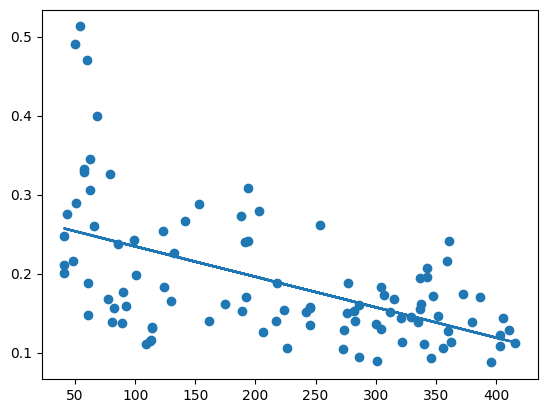

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     40.83
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           5.78e-09
Time:                        17:45:44   Log-Likelihood:                 121.94
No. Observations:                  99   AIC:                            -239.9
Df Residuals:                      97   BIC:                            -234.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2729      0.015     18.

In [9]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

# set variables
x = etc_tune['tune_num_train']
y = etc_tune['tune_mses_train']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Training Data & Testing MSE

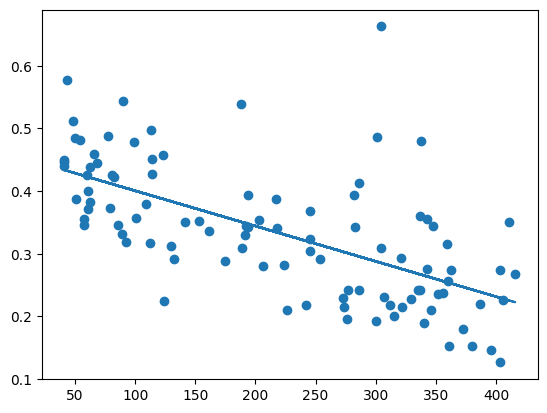

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     64.76
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           2.13e-12
Time:                        17:46:17   Log-Likelihood:                 107.09
No. Observations:                  99   AIC:                            -210.2
Df Residuals:                      97   BIC:                            -205.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4567      0.017     26.

In [10]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_num_train']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Testing Data & Training MSE

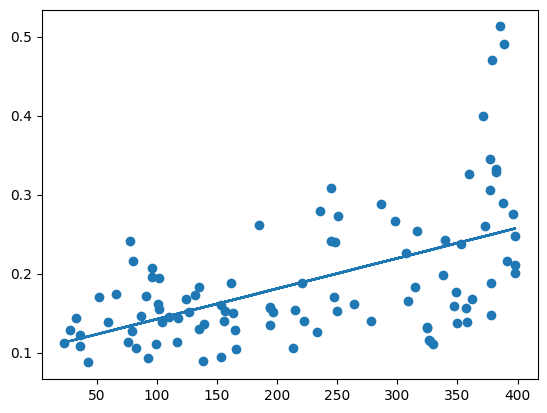

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     40.83
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           5.78e-09
Time:                        17:46:47   Log-Likelihood:                 121.94
No. Observations:                  99   AIC:                            -239.9
Df Residuals:                      97   BIC:                            -234.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1040      0.015      6.816

In [11]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_num_test']
y = etc_tune['tune_mses_train']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Testing Data & Testing MSE

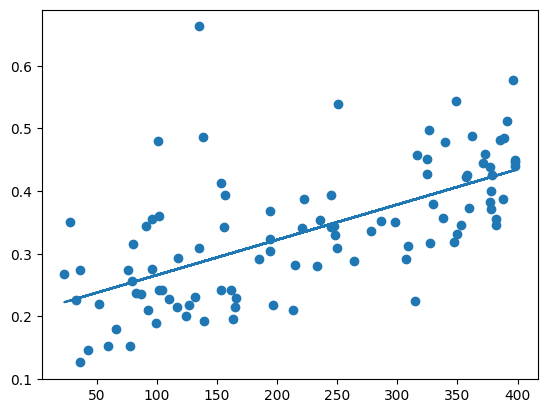

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     64.76
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           2.13e-12
Time:                        17:47:30   Log-Likelihood:                 107.09
No. Observations:                  99   AIC:                            -210.2
Df Residuals:                      97   BIC:                            -205.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2096      0.018     11.826

In [12]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_num_test']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Labeled Data & Training MSE

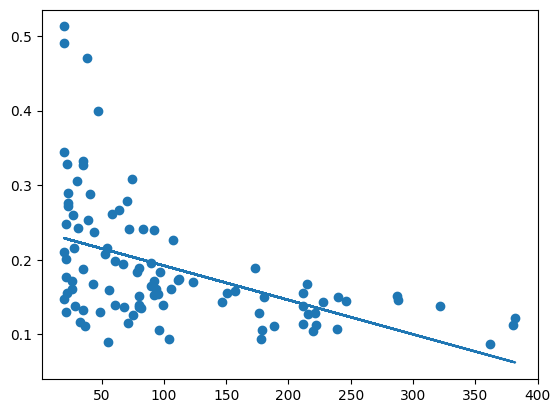

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     29.36
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           4.37e-07
Time:                        17:47:47   Log-Likelihood:                 117.64
No. Observations:                  99   AIC:                            -231.3
Df Residuals:                      97   BIC:                            -226.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2382      0.012  

In [13]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_num_labeled']
y = etc_tune['tune_mses_train']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Labeled Data & Testing MSE

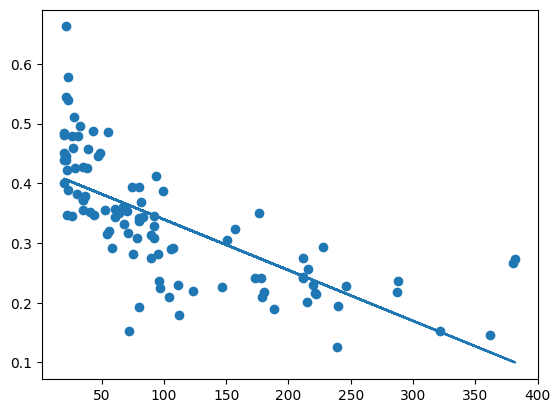

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     97.10
Date:                Mon, 01 May 2023   Prob (F-statistic):           2.77e-16
Time:                        16:17:46   Log-Likelihood:                 116.11
No. Observations:                  99   AIC:                            -228.2
Df Residuals:                      97   BIC:                            -223.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4244      0.012  

In [15]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_num_labeled']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

In [11]:
etc_tune['log_labeled'] = np.log(etc_tune['tune_num_labeled'])

In [12]:
etc_tune

,tune_mses_test,tune_mses_train,tune_mses1_test,tune_mses1_train,tune_mses2_test,tune_mses2_train,tune_maes_test,tune_maes_train,tune_maes1_test,tune_maes1_train,...,tune_num_test,tune_num_labeled,tune_num_unlabeled,tune_pool_size,tune_max_iters,tune_k1,tune_k2,tune_p1,tune_p2,log_labeled
0,0.317514,0.115149,0.339100,0.137327,0.313306,0.105453,0.397343,0.271736,0.406163,0.291108,...,327,71,41,61,41,6,4,4,7,4.262680
1,0.210208,0.105927,0.201596,0.140204,0.254877,0.096162,0.322521,0.227953,0.321140,0.261825,...,213,179,47,134,47,4,3,2,1,5.187386
2,0.273899,0.122513,0.286615,0.129330,0.264329,0.118103,0.342134,0.245226,0.357408,0.251759,...,36,382,21,377,21,7,7,6,3,5.945421
3,0.192332,0.136173,0.192317,0.161391,0.223849,0.126195,0.286649,0.276660,0.292805,0.287867,...,139,80,220,162,220,3,3,4,3,4.382027
4,0.314909,0.216389,0.327135,0.199028,0.324037,0.245980,0.376207,0.366629,0.394659,0.347137,...,80,54,305,284,305,3,9,8,7,3.988984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.368393,0.135142,0.375881,0.164276,0.379807,0.120476,0.440453,0.290314,0.443736,0.314177,...,194,82,163,46,163,7,4,2,5,4.406719
95,0.304622,0.156101,0.319806,0.187567,0.308752,0.143919,0.381285,0.278747,0.390190,0.310147,...,194,151,94,164,94,8,4,8,3,5.017280
96,0.336682,0.140130,0.359677,0.188257,0.349139,0.117937,0.434470,0.272745,0.445519,0.310314,...,278,80,81,44,81,6,4,4,1,4.382027
97,0.267158,0.112606,0.266507,0.149971,0.288064,0.103704,0.368692,0.228606,0.366123,0.270655,...,23,380,36,310,36,9,5,6,1,5.940171


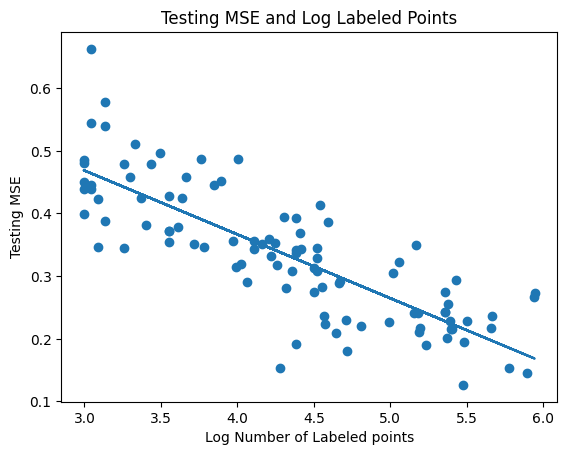

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     189.9
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.42e-24
Time:                        16:49:59   Log-Likelihood:                 135.46
No. Observations:                  99   AIC:                            -266.9
Df Residuals:                      97   BIC:                            -261.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7742      0.032     23.864      

In [22]:
x = etc_tune['log_labeled']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Testing MSE and Log Labeled Points") #title
plt.xlabel("Log Number of Labeled points") #x label
plt.ylabel("Testing MSE") #y label
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Unlabeled Data & Training MSE

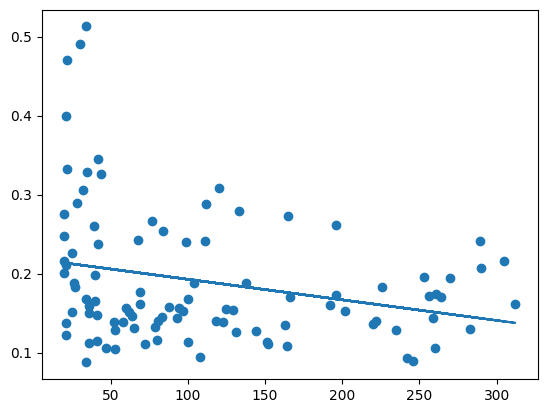

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.178
Date:                Sat, 29 Apr 2023   Prob (F-statistic):            0.00867
Time:                        17:48:51   Log-Likelihood:                 108.08
No. Observations:                  99   AIC:                            -212.2
Df Residuals:                      97   BIC:                            -207.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2188      0

In [15]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_num_unlabeled']
y = etc_tune['tune_mses_train']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Unlabeled Data & Testing MSE

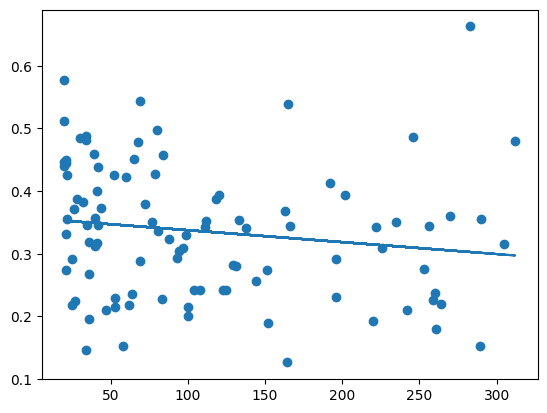

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.312
Date:                Sat, 29 Apr 2023   Prob (F-statistic):              0.132
Time:                        17:49:27   Log-Likelihood:                 82.941
No. Observations:                  99   AIC:                            -161.9
Df Residuals:                      97   BIC:                            -156.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3566      0

In [16]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_num_unlabeled']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Pool Size & Training MSE

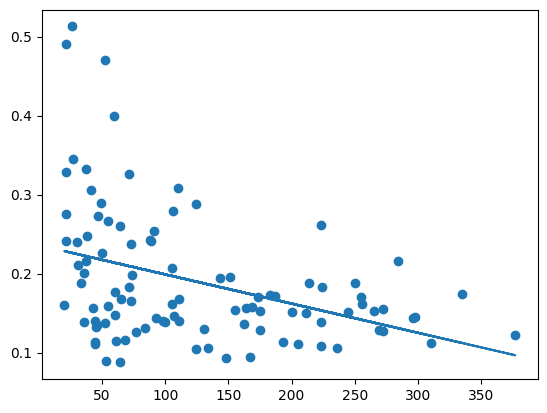

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     16.96
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           8.03e-05
Time:                        18:18:53   Log-Likelihood:                 112.52
No. Observations:                  99   AIC:                            -221.0
Df Residuals:                      97   BIC:                            -215.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2359      0.014     17.

In [23]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_pool_size']
y = etc_tune['tune_mses_train']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Pool Size & Testing MSE

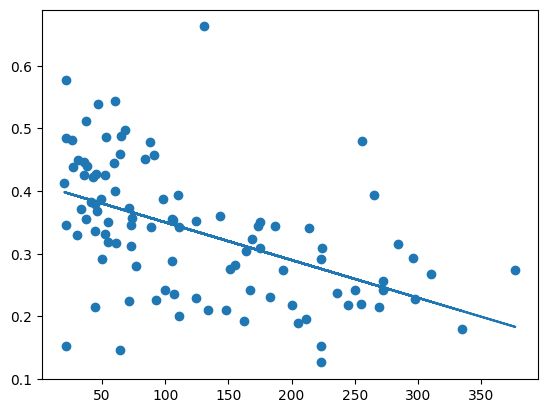

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     32.34
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           1.37e-07
Time:                        18:18:58   Log-Likelihood:                 96.016
No. Observations:                  99   AIC:                            -188.0
Df Residuals:                      97   BIC:                            -182.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4103      0.016     25.

In [24]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_pool_size']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Co-Training Iterations & Training MSE



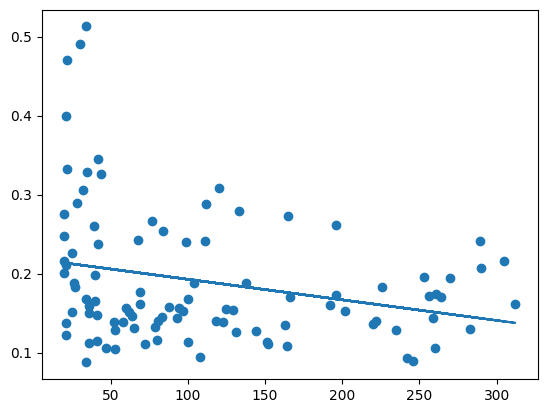

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.178
Date:                Sat, 29 Apr 2023   Prob (F-statistic):            0.00867
Time:                        18:19:02   Log-Likelihood:                 108.08
No. Observations:                  99   AIC:                            -212.2
Df Residuals:                      97   BIC:                            -207.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2188      0.014     16.

In [25]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_max_iters']
y = etc_tune['tune_mses_train']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### Co-Training Iterations & Testing MSE



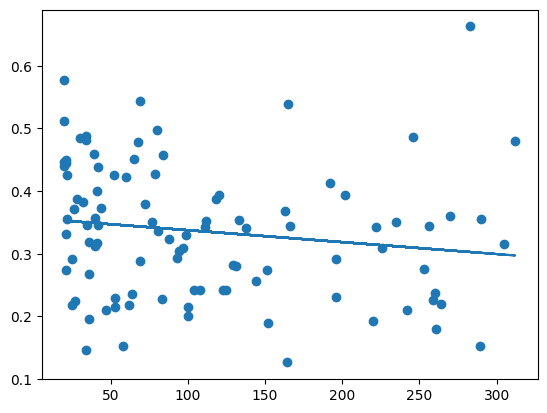

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.312
Date:                Sat, 29 Apr 2023   Prob (F-statistic):              0.132
Time:                        18:19:05   Log-Likelihood:                 82.941
No. Observations:                  99   AIC:                            -161.9
Df Residuals:                      97   BIC:                            -156.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3566      0.017     20.

In [26]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_max_iters']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### K1 & Training MSE

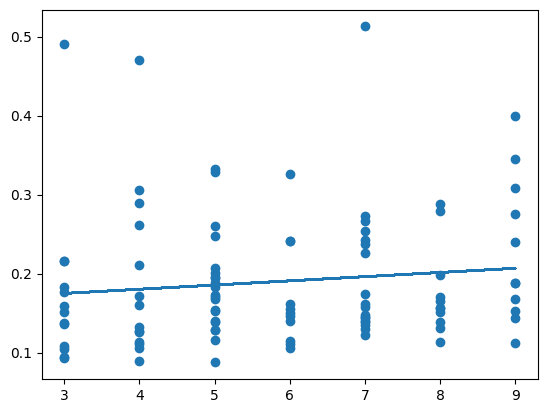

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.389
Date:                Sat, 29 Apr 2023   Prob (F-statistic):              0.241
Time:                        18:19:09   Log-Likelihood:                 105.25
No. Observations:                  99   AIC:                            -206.5
Df Residuals:                      97   BIC:                            -201.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1590      0.028      5.757      0.0

In [27]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_k1']
y = etc_tune['tune_mses_train']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### K1 & Testing MSE

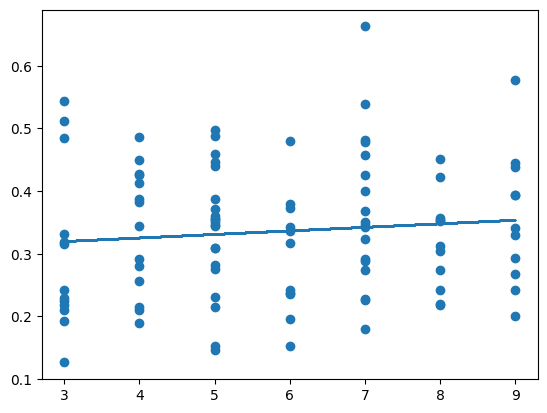

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9978
Date:                Sat, 29 Apr 2023   Prob (F-statistic):              0.320
Time:                        18:19:13   Log-Likelihood:                 82.281
No. Observations:                  99   AIC:                            -160.6
Df Residuals:                      97   BIC:                            -155.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3024      0.035      8.679      0.0

In [28]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_k1']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### K2 & Training MSE

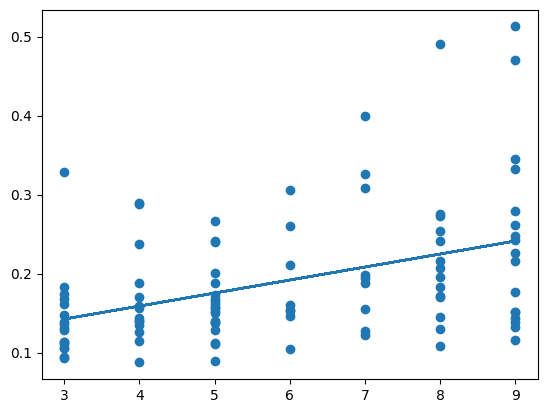

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     20.17
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           1.96e-05
Time:                        18:19:17   Log-Likelihood:                 113.90
No. Observations:                  99   AIC:                            -223.8
Df Residuals:                      97   BIC:                            -218.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0931      0.023      4.060      0.0

In [29]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_k2']
y = etc_tune['tune_mses_train']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### K2 & Testing MSE

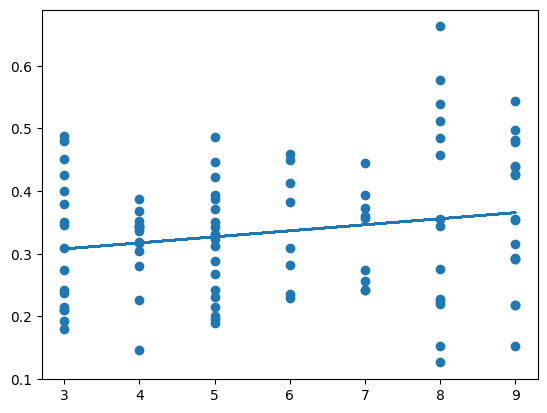

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.755
Date:                Sat, 29 Apr 2023   Prob (F-statistic):             0.0555
Time:                        18:19:21   Log-Likelihood:                 83.655
No. Observations:                  99   AIC:                            -163.3
Df Residuals:                      97   BIC:                            -158.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2788      0.031      8.954      0.0

In [30]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_k2']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### P1 & Training MSE

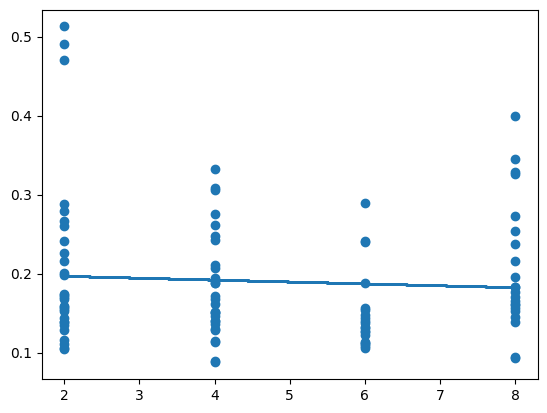

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.3988
Date:                Sat, 29 Apr 2023   Prob (F-statistic):              0.529
Time:                        18:19:26   Log-Likelihood:                 104.75
No. Observations:                  99   AIC:                            -205.5
Df Residuals:                      97   BIC:                            -200.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2013      0.020     10.159      0.0

In [31]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_p1']
y = etc_tune['tune_mses_train']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### P1 & Testing MSE

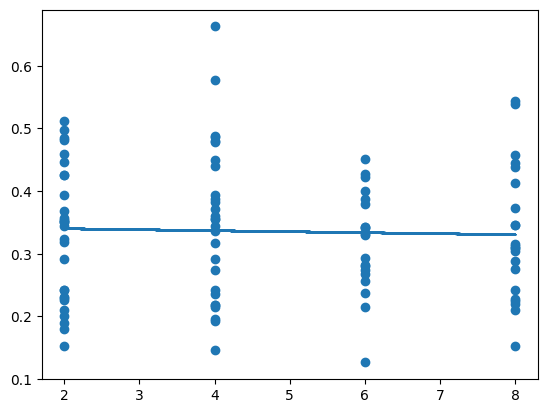

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.1111
Date:                Sat, 29 Apr 2023   Prob (F-statistic):              0.740
Time:                        18:19:30   Log-Likelihood:                 81.831
No. Observations:                  99   AIC:                            -159.7
Df Residuals:                      97   BIC:                            -154.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3430      0.025     13.732      0.0

In [32]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_p1']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### P2 & Training MSE

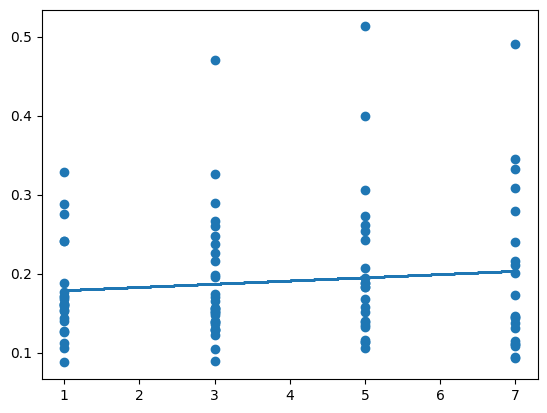

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.040
Date:                Sat, 29 Apr 2023   Prob (F-statistic):              0.310
Time:                        18:19:34   Log-Likelihood:                 105.07
No. Observations:                  99   AIC:                            -206.1
Df Residuals:                      97   BIC:                            -201.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1743      0.018      9.890      0.0

In [33]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_p2']
y = etc_tune['tune_mses_train']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

### P2 & Testing MSE

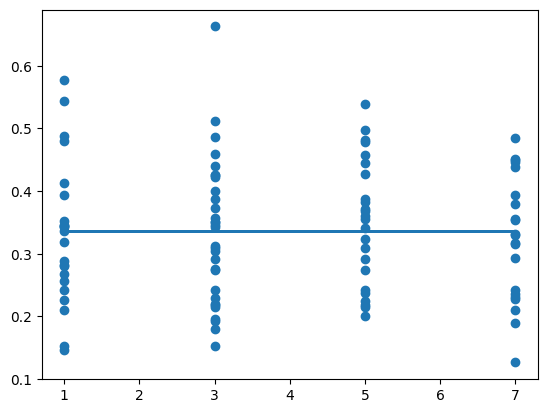

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                 0.0005696
Date:                Sat, 29 Apr 2023   Prob (F-statistic):              0.981
Time:                        18:19:37   Log-Likelihood:                 81.775
No. Observations:                  99   AIC:                            -159.5
Df Residuals:                      97   BIC:                            -154.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3360      0.022     15.067      0.0

In [34]:
# Code based off of: 
  # https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html
  # https://realpython.com/linear-regression-in-python/

x = etc_tune['tune_p2']
y = etc_tune['tune_mses_test']

# regression model
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

## Multiple Feature Analysis

### Training Data MLR

The following features had statistically significant relationships to **training** MSE:
* Amount of testing / training data
* KNN regressor co-trainer (k)

The following features had statistically insignificant relationships to training MSE:
* Amount of labeled / unlabeled data
* pool size
* Co-training iterations
* Distance of KNN regressor co-trainer (p)

### Testing Data MLR

The following features had statistically significant relationships to **testing** MSE:
* Amount of testing / training data
* KNN regressor co-trainer (k)
* Co-training iterations

The following features had statistically insignificant relationships to training MSE:
* Amount of labeled / unlabeled data
* pool size
* Distance of KNN regressor co-trainer (p)


### Multiple Linear Regression

In [18]:
etc_x = etc_tune.drop(['tune_mses_test', 'tune_mses_train', 
                       'tune_mses1_test', 'tune_mses1_train',
                       'tune_mses2_test', 'tune_mses2_train',
                       
                       'tune_maes_test', 'tune_maes_train',
                       'tune_maes1_test', 'tune_maes1_train',
                       'tune_maes2_test', 'tune_maes2_train',
                       
                       'tune_num_train', 'tune_num_unlabeled',
                       'tune_num_labeled'], axis=1)

* I removed `tune_num_train` as all the points are either assigned to testing or training data (meaning that `tune_num_test` captures the information needed in `tune_num_train`).

  * In addition, the training data is further split into `tune_num_labeled` and `tune_num_unlabeled`.

* For similar reasons, I also removed `tune_num_unlabeled`.

#### Training Data MLR

In [19]:
# Code based off of: https://realpython.com/linear-regression-in-python/

x = etc_x
y = etc_tune['tune_mses_train']

# regression
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        tune_mses_train   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     10.77
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.64e-10
Time:                        16:19:26   Log-Likelihood:                 137.78
No. Observations:                  99   AIC:                            -257.6
Df Residuals:                      90   BIC:                            -234.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1388      0.168      0.

#### Testing Data MLR

In [20]:
# Code based off of: https://realpython.com/linear-regression-in-python/

x = etc_x
y = etc_tune['tune_mses_test']

# regression
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         tune_mses_test   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     27.33
Date:                Mon, 01 May 2023   Prob (F-statistic):           5.17e-21
Time:                        16:20:35   Log-Likelihood:                 142.78
No. Observations:                  99   AIC:                            -267.6
Df Residuals:                      90   BIC:                            -244.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9332      0.160      5.

In [1]:
import numpy as np
import pandas as pd

In [2]:
etc_tune = pd.read_csv('etc_tune.csv')

In [5]:
etc_tune['tune_mses_test'].describe()

count    99.000000
mean      0.335507
std       0.106473
min       0.126410
25%       0.241964
50%       0.341617
75%       0.406422
max       0.662662
Name: tune_mses_test, dtype: float64

# Hyperparameter Tuned Model

Of the 100 Co-Regression models, the model which predicted detonation velocity with the most accuracy (test MSE 0.13, train MSE 0.11), used the following hyperparameters:

* Training data: 403 points
  * labeled data: 239 points
  * unlabeled data: 164 points
* Testing data: 36 points

* Pool size: 223 points
* Co-training iterations: 164

* k1 = 3
* k2 = 8
* p1 = 6
* p2 = 7

In [56]:
etc_final = etc_tune.drop(['tune_mses1_test', 'tune_mses1_train',
                       'tune_mses2_test', 'tune_mses2_train',
                       
                       'tune_maes_test', 'tune_maes_train',
                       'tune_maes1_test', 'tune_maes1_train',
                       'tune_maes2_test', 'tune_maes2_train'], axis=1)

# Code based off of: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.htm
etc_final = etc_final.sort_values(by=['tune_mses_test'])
etc_final = etc_final[:1]
etc_final

,tune_mses_test,tune_mses_train,tune_num_train,tune_num_test,tune_num_labeled,tune_num_unlabeled,tune_pool_size,tune_max_iters,tune_k1,tune_k2,tune_p1,tune_p2
80,0.12641,0.10779,403,36,239,164,223,164,3,8,6,7
